<a href="https://colab.research.google.com/github/Jaguar838/llm-zoomcamp/blob/main/HW/2025/workshops/workshops-03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **From REST to reasoning: ingest, index, and query with dlt and Cognee.**

## **Taxi dataset example**

## **Let's install Cognee and Kuzu**

- [Cognee](https://www.cognee.ai/) is an open-source python library, connects data points and establishes ground truths to improve the accuracy of your AI agents and LLMs.
- [Kuzu](https://kuzudb.com/) is an open-source embedded, scalable, blazing fast graph database.

Read more about Cognee and Kuzu here: https://blog.kuzudb.com/post/cognee-kuzu-relational-data-to-knowledge-graph/

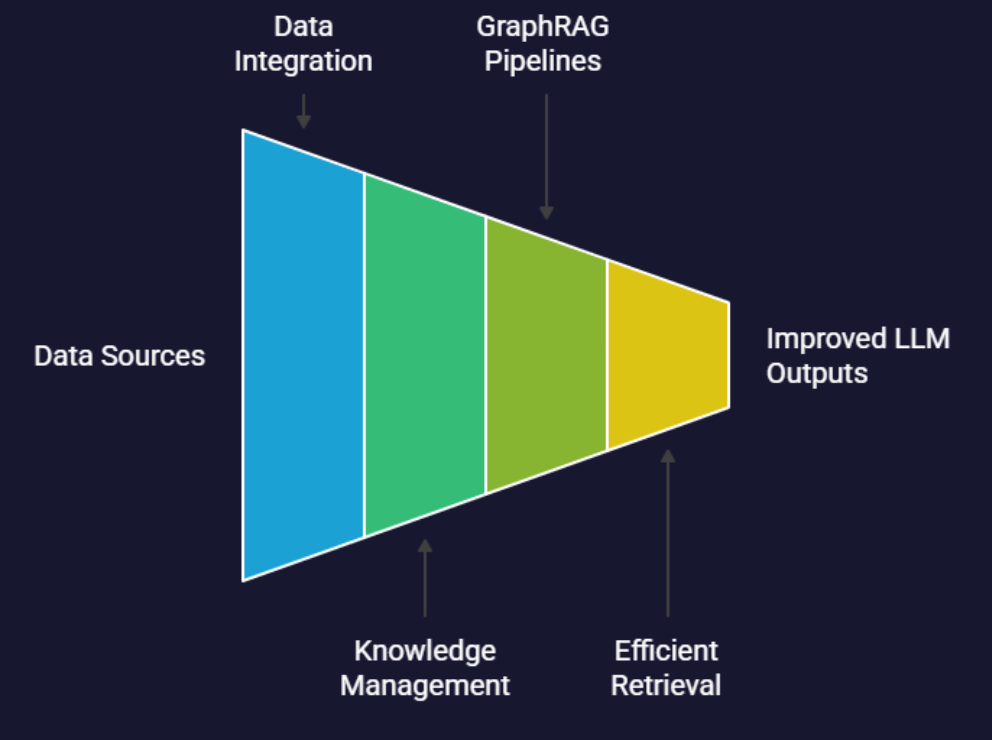

In [ ]:
%%capture
!pip install cognee
!pip install kuzu

Before running Cognee you have to specify up your environment.

Cognee relies on third-party LLM providers and you have a [great choice of them](https://docs.cognee.ai/how-to-guides/remote-models) you can use in your workflow.

**The simple way**

Just provide your OpenAI API key if you already have one. This will help you both with LLM and embeddings.

In [ ]:
from google.colab import userdata
import os

os.environ["LLM_API_KEY"] = userdata.get('OPENAI_API_KEY') # it can be OpenAI API key
os.environ['HTTP_PROXY'] = userdata.get('HTTP_PROXY')
os.environ["GRAPH_DATABASE_PROVIDER"] = "kuzu"

## **Data we'll be using**

In this example, we’ll request data from an API that serves the **NYC taxi dataset**. For these purposes we created an API that can serve the data you are already familiar with.

### **API documentation**:  
- **Data**: Comes in pages of 1,000 records.  
- **Pagination**: When there’s no more data, the API returns an empty page.  
- **Details**:  
  - **Method**: GET  
  - **URL**: `https://us-central1-dlthub-analytics.cloudfunctions.net/data_engineering_zoomcamp_api`  
  - **Parameters**:  
    - `page`: Integer (page number), defaults to 1.  

Here’s how we design our requester:  
1. **Request page by page** until we hit an empty page. Since we don’t know how much data is behind the API, we must assume it could be as little as 1,000 records or as much as 10GB.
2. **Use a generator** to handle this efficiently and avoid loading all data into memory.  

The dates for taxi rides are all from within June 2009.

## **We'll be partitioning our data in our own way**

1. first_10_days
2. second_10_days
3. last_10_days

We'll be doing this manually for clarity, but dlt also supports partitioning, as you can find [here](https://dlthub.com/docs/plus/ecosystem/iceberg#partitioning).

In [ ]:
!dlt --version

dlt 1.12.3


In [ ]:
import dlt
import requests
import pandas as pd
from datetime import datetime

# Step 1: Create DLT resource
@dlt.resource(write_disposition="replace", name="zoomcamp_data")
def zoomcamp_data():
    url = "https://us-central1-dlthub-analytics.cloudfunctions.net/data_engineering_zoomcamp_api"
    response = requests.get(url)
    data = response.json()

    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['Trip_Pickup_DateTime'] = pd.to_datetime(df['Trip_Pickup_DateTime'])

    # Define buckets
    df['tag'] = pd.cut(
        df['Trip_Pickup_DateTime'],
        bins=[
            pd.Timestamp("2009-06-01"),
            pd.Timestamp("2009-06-10"),
            pd.Timestamp("2009-06-20"),
            pd.Timestamp("2009-06-30")
        ],
        labels=["first_10_days", "second_10_days", "last_10_days"],
        right=False
    )

    # Drop rows not in the specified range
    df = df[df['tag'].notnull()]
    yield df


# Step 2: Create and run the pipeline
pipeline = dlt.pipeline(
    pipeline_name="zoomcamp_pipeline",
    destination="duckdb",
    dataset_name="zoomcamp_tagged_data"
)
load_info = pipeline.run(zoomcamp_data())
print(pipeline.last_trace)

2025-07-07 17:57:43,821|[WARNING]|1677|138351732604928|dlt|validate.py|verify_normalized_table:57|In schema `zoomcamp`: The following columns in table 'zoomcamp_data' did not receive any data during this load and therefore could not have their types inferred:
  - rate_code
  - mta_tax

Unless type hints are provided, these columns will not be materialized in the destination.
One way to provide type hints is to use the 'columns' argument in the '@dlt.resource' decorator.  For example:

@dlt.resource(columns={'rate_code': {'data_type': 'text'}})



Run started at 2025-07-07 17:57:40.719527+00:00 and COMPLETED in 3.44 seconds with 4 steps.
Step extract COMPLETED in 2.49 seconds.

Load package 1751911061.3230011 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.03 seconds.
Normalized data for the following tables:
- zoomcamp_data: 998 row(s)
- _dlt_pipeline_state: 1 row(s)

Load package 1751911061.3230011 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.33 seconds.
Pipeline zoomcamp_pipeline load step completed in 0.21 seconds
1 load package(s) were loaded to destination duckdb and into dataset zoomcamp_tagged_data
The duckdb destination used duckdb:////content/zoomcamp_pipeline.duckdb location to store data
Load package 1751911061.3230011 is LOADED and contains no failed jobs

Step run COMPLETED in 3.44 seconds.
Pipeline zoomcamp_pipeline load step completed in 0.21 seconds
1 load package(s) were loaded to destinati

In [ ]:
dataset = pipeline.dataset().zoomcamp_data.df()

dataset

,end_lat,end_lon,fare_amt,passenger_count,payment_type,start_lat,start_lon,tip_amt,tolls_amt,total_amt,trip_distance,trip_dropoff_date_time,trip_pickup_date_time,store_and_forward,surcharge,vendor_name,tag
0,40.742963,-73.980072,45.0,1,Credit,40.641525,-73.787442,9.0,4.15,58.15,17.52,2009-06-14 23:48:00,2009-06-14 23:23:00,NaN,0.0,VTS,second_10_days
1,40.740187,-74.005698,6.5,1,Credit,40.722065,-74.009767,1.0,0.00,8.50,1.56,2009-06-18 17:43:00,2009-06-18 17:35:00,NaN,1.0,VTS,second_10_days
2,40.718043,-74.004745,12.5,5,Credit,40.761945,-73.983038,2.0,0.00,15.50,3.37,2009-06-10 18:27:00,2009-06-10 18:08:00,NaN,1.0,VTS,second_10_days
3,40.739637,-73.985233,4.9,1,CASH,40.749802,-73.992247,0.0,0.00,5.40,1.11,2009-06-14 23:58:00,2009-06-14 23:54:00,NaN,0.5,VTS,second_10_days
4,40.730032,-73.852693,25.7,1,CASH,40.776825,-73.949233,0.0,4.15,29.85,11.09,2009-06-13 13:23:00,2009-06-13 13:01:00,NaN,0.0,VTS,second_10_days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,40.742998,-73.919065,6.9,1,CASH,40.743523,-73.918735,0.0,0.00,6.90,1.83,2009-06-10 06:23:00,2009-06-10 06:16:00,NaN,0.0,VTS,second_10_days
994,40.731953,-73.985330,7.3,1,CASH,40.733143,-74.006408,0.0,0.00,7.80,1.59,2009-06-10 05:11:00,2009-06-10 05:02:00,NaN,0.5,VTS,second_10_days
995,40.712640,-73.998870,5.7,1,CASH,40.711865,-74.010158,0.0,0.00,5.70,0.79,2009-06-13 12:45:00,2009-06-13 12:37:00,NaN,0.0,VTS,second_10_days
996,40.732998,-74.007113,7.3,2,CASH,40.744658,-73.992063,0.0,0.00,7.80,1.87,2009-06-09 21:34:00,2009-06-09 21:25:00,NaN,0.5,VTS,first_10_days


In [ ]:
dataset["tag"].value_counts()

,count
tag,
first_10_days,481
second_10_days,295
last_10_days,222


## **Lets load data into Cognee!**

Here, I am using `cognee.add()` and then `cognee.cognify()` directly.

If you'd like to learn about how to use relational datasets in cognee, please visit the [docs](https://docs.cognee.ai/tutorials/load-your-relational-database) :)

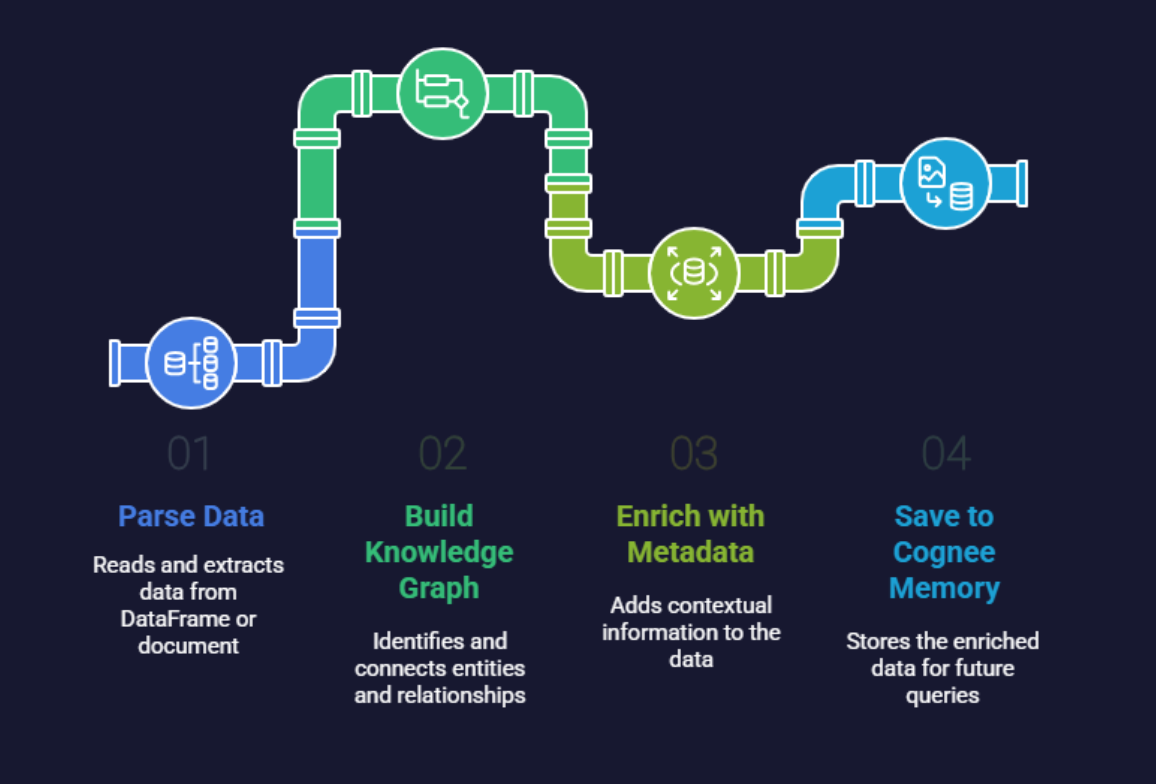

In [ ]:
help(dlt)

Help on package dlt:

NAME
    dlt - data load tool (dlt) — the open-source Python library for data loading

DESCRIPTION
    How to create a data loading pipeline with dlt in 3 seconds:
    
    1. Write a pipeline script
    >>> import dlt
    >>> from dlt.sources.helpers import requests
    >>> dlt.run(requests.get("https://pokeapi.co/api/v2/pokemon/").json()["results"], destination="duckdb", table_name="pokemon")
    
    2. Run your pipeline script
      > $ python pokemon.py
    
    3. See and query your data with autogenerated Streamlit app
      > $ dlt pipeline dlt_pokemon show
    
    Or start with our pipeline template with sample PokeAPI (pokeapi.co) data loaded to bigquery
    
      > $ dlt init pokemon bigquery
    
    For more detailed info, see https://dlthub.com/docs/getting-started

PACKAGE CONTENTS
    __main__
    cli (package)
    common (package)
    destinations (package)
    extract (package)
    helpers (package)
    load (package)
    normalize (package)
  

In [ ]:
help(cognee)

Help on package cognee:

NAME
    cognee - # ruff: noqa: E402

PACKAGE CONTENTS
    api (package)
    base_config
    context_global_variables
    eval_framework (package)
    exceptions (package)
    get_token
    infrastructure (package)
    low_level
    modules (package)
    pipelines
    root_dir
    shared (package)
    tests (package)
    version

SUBMODULES
    start_visualization_server
    tasks

DATA
    logger = <BoundLoggerLazyProxy(logger=None, wrapper_class...r_factory_...

VERSION
    0.2.0

FILE
    /usr/local/lib/python3.11/dist-packages/cognee/__init__.py




In [ ]:
import cognee
from cognee.shared.logging_utils import get_logger, ERROR
from cognee.api.v1.visualize.visualize import visualize_graph
from cognee.api.v1.search import SearchType
from cognee.modules.engine.models import NodeSet
import os

async def main():
    await cognee.prune.prune_data()
    await cognee.prune.prune_system(metadata=True)

    # Add the first 10 days
    df_set1 = dataset.loc[dataset["tag"] == "first_10_days"]
    df_set1.drop(columns=["tag"], inplace=True)
    df_set1 = df_set1.to_json(orient="records", lines=False)
    await cognee.add(df_set1, node_set=["first_10_days"])

    # Add the second 10 days
    df_set2 = dataset.loc[dataset["tag"] == "second_10_days"]
    df_set2.drop(columns=["tag"], inplace=True)
    df_set2 = df_set2.to_json(orient="records", lines=False)
    await cognee.add(df_set2, node_set=["second_10_days"])

    # Add the last 10 days
    df_set3 = dataset.loc[dataset["tag"] == "last_10_days"]
    df_set3.drop(columns=["tag"], inplace=True)
    df_set3 = df_set3.to_json(orient="records", lines=False)
    await cognee.add(df_set3, node_set=["last_10_days"])

    await cognee.cognify()

    visualization_path = "/content/.artifacts/graph_visualization.html"
    await visualize_graph(visualization_path)


2025-07-07T18:02:58.599808 [info     ] Logging initialized            [cognee.shared.logging_utils] cognee_version=0.2.0 os_info='Linux 6.1.123+ (#1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025)' python_version=3.11.13 structlog_version=25.4.0

2025-07-07T18:02:58.600932 [info     ] Want to learn more? Visit the Cognee documentation: https://docs.cognee.ai [cognee.shared.logging_utils]

HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


Run the `main()` function. It might take some time, so go ahead and grab a cup of coffee. 🫖

In [ ]:
#!pip freeze > requirements.txt
!cat requirements.txt

absl-py==1.4.0
accelerate==1.8.1
aiobotocore==2.23.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aioitertools==0.12.0
aiosignal==1.3.2
aiosqlite==0.20.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.1
alembic==1.16.2
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.6.30.0.39.40
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backoff==2.2.1
backports.tarfile==1.2.0
backrefs==5.9
bcrypt==4.3.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.8.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.5.0
bokeh==3.7.3
boto3==1.38.27
botocore==1.38.27
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.6.15
cffi==1.

In [ ]:
await main()

### **Look at the knowledge graph**



In [ ]:
from google.colab import files

files.download("/content/.artifacts/graph_visualization.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Search**

In [ ]:
async def search_cognee(query, node_set, query_type=SearchType.GRAPH_COMPLETION):
    answer = await cognee.search(
        query_text=query,
        query_type=query_type,
        node_type=NodeSet,
        node_name=node_set,
        top_k=5 # limit search for retrieval
    )
    return answer

In [ ]:
results = await search_cognee(
    "What's in this knowledge graph?",
    node_set=["first_10_days"]
)

12:28:21 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large12:28:21 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large12:28:21 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large12:28:21 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large12:28:21 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large12:28:21 - LiteLLM:INFO: cost_calcu

In [ ]:
print(results[0])

The knowledge graph contains nodes that represent different trips (trip 5, 6, 17, 18, 37, and 38) and their relationships. The connections indicate that:
- trip 6 is related to trip 5
- trip 17 is related to trip 18
- trip 18 is related to trip 17
- trip 37 is related to trip 38
- trip 38 is related to trip 37

This suggests a network of related trips.


In [ ]:
!pip install -q "dlt[qdrant]" "qdrant-client[fastembed]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.0/329.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 27.8 MB/s eta 0:00:00


In [ ]:
import dlt
import requests
from dlt.destinations import qdrant

@dlt.resource
def zoomcamp_data():
    docs_url = 'https://github.com/alexeygrigorev/llm-rag-workshop/raw/main/notebooks/documents.json'
    docs_response = requests.get(docs_url)
    documents_raw = docs_response.json()

    for course in documents_raw:
        course_name = course['course']

        for doc in course['documents']:
            doc['course'] = course_name
            yield doc

qdrant_destination = qdrant(
  qd_path="db.qdrant",
)

pipeline = dlt.pipeline(
    pipeline_name="zoomcamp_pipeline",
    destination=qdrant_destination,
    dataset_name="zoomcamp_tagged_data"
)

load_info = pipeline.run(zoomcamp_data(), table_name="zoomcamp_data")
print(load_info)

Pipeline zoomcamp_pipeline load step completed in 10.26 seconds
1 load package(s) were loaded to destination qdrant and into dataset zoomcamp_tagged_data
The qdrant destination used /content/db.qdrant location to store data
Load package 1751915613.796895 is LOADED and contains no failed jobs


In [ ]:
type(load_info)

dlt.common.pipeline.LoadInfo

In [ ]:
!cat db.qdrant/meta.json

{"collections": {"zoomcamp_tagged_data": {"vectors": {"fast-bge-small-en": {"size": 384, "distance": "Cosine", "hnsw_config": null, "quantization_config": null, "on_disk": null, "datatype": null, "multivector_config": null}}, "shard_number": null, "sharding_method": null, "replication_factor": null, "write_consistency_factor": null, "on_disk_payload": null, "hnsw_config": null, "wal_config": null, "optimizers_config": null, "init_from": null, "quantization_config": null, "sparse_vectors": null, "strict_mode_config": null}, "zoomcamp_tagged_data__dlt_loads": {"vectors": {"fast-bge-small-en": {"size": 384, "distance": "Cosine", "hnsw_config": null, "quantization_config": null, "on_disk": null, "datatype": null, "multivector_config": null}}, "shard_number": null, "sharding_method": null, "replication_factor": null, "write_consistency_factor": null, "on_disk_payload": null, "hnsw_config": null, "wal_config": null, "optimizers_config": null, "init_from": null, "quantization_config": null, "

In [ ]:
!dlt --version

dlt 1.12.3


In [ ]:
print(pipeline.last_trace)

Run started at 2025-07-07 19:13:33.226625+00:00 and COMPLETED in 11.23 seconds with 4 steps.
Step extract COMPLETED in 0.31 seconds.

Load package 1751915613.796895 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.09 seconds.
Normalized data for the following tables:
- zoomcamp_data: 948 row(s)

Load package 1751915613.796895 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 10.28 seconds.
Pipeline zoomcamp_pipeline load step completed in 10.26 seconds
1 load package(s) were loaded to destination qdrant and into dataset zoomcamp_tagged_data
The qdrant destination used /content/db.qdrant location to store data
Load package 1751915613.796895 is LOADED and contains no failed jobs

Step run COMPLETED in 11.23 seconds.
Pipeline zoomcamp_pipeline load step completed in 10.26 seconds
1 load package(s) were loaded to destination qdrant and into dataset zoomcamp_tagged_data
The qdr